# Project 2

For this project, I am going to build classification models to predict if a person is diabetic or not given certain features. My main goal for this project is to understand various classification algorithms on a deeper level and be able to compare them.

## Inspecting the data


In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy.stats as stats


In [2]:
# read data
data = pd.read_csv('/content/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

In [3]:
# inspect shape, columns, nulls, datatypes
data.shape

(70692, 22)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

There are no nulls so that is great.

In [5]:
data.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


After inpsecting the data, I see that there are 2 types of variables in the dataset: categorical and numerical variables. So, instead of calculating correlation normally, I will need to use Cramer's V to calculate the correlation between each of the categorical value with the target and point biserial between the numerical value with the target.

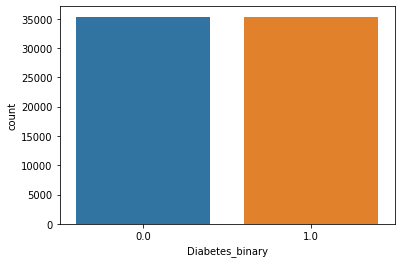

In [6]:
# Check see if data is balanced
ax = sns.countplot(x="Diabetes_binary", data=data)

In [7]:
data['Diabetes_binary'].value_counts()

0.0    35346
1.0    35346
Name: Diabetes_binary, dtype: int64

Data is perfectly balanced.


## Preprocessing - Calculating Correlation

First, I will calculate the correlation between numerical data and categorical data using Point Biserial. A result of 1 means there is a positive correlation, 0 means there is no correlation, and -1 means there is a negative correlation.

In [8]:
# calculate point-biserial correlation between BMI and target
x = data['Diabetes_binary'].to_numpy()
y = data['BMI'].to_numpy()
stats.pointbiserialr(x, y)

PointbiserialrResult(correlation=0.29337274476104624, pvalue=0.0)

In [9]:
# similarly, correlation between target and mental health days
x = data['Diabetes_binary'].to_numpy()
y = data['MentHlth'].to_numpy()
stats.pointbiserialr(x, y)

PointbiserialrResult(correlation=0.08702877147509541, pvalue=6.795439709628024e-119)

In [10]:
# correlation between target and days with physical illness or injury
x = data['Diabetes_binary'].to_numpy()
y = data['PhysHlth'].to_numpy()
stats.pointbiserialr(x, y)

PointbiserialrResult(correlation=0.21308101903810778, pvalue=0.0)

Since the p-value of all 3 correlations are less than .05, they are statistically significant. 

Now I will use Cramer's V to calculate correlation between the categorical variables. A result of 1 means highly associated, 0 means not.

In [11]:
# define cramers_v function
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [12]:
# New dataframe with only categorical values
data2 = data.copy()
data2 = data2.drop(columns=['BMI', 'MentHlth', 'PhysHlth'])
data2

,Diabetes_binary,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,5.0,1.0,0.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,0.0,11.0,2.0,4.0


In [13]:
# Make empty dataframe
df_cramers = pd.DataFrame(index = data2.columns, columns = data2.columns)
# Use the function above to calculate cramers_v
for col in df_cramers.columns:
    for row in df_cramers.index:
        df_cramers[col][row] = cramers_v(data2[col], data2[row])

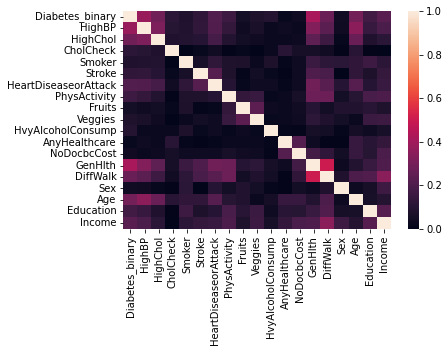

In [14]:
# Visualize it
sns.heatmap(df_cramers.astype(float))

In [15]:
df_cramers

,Diabetes_binary,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,DiffWalk,Sex,Age,Education,Income
Diabetes_binary,0.999972,0.381471,0.289162,0.11523,0.085889,0.125313,0.211452,0.158591,0.053917,0.07917,0.094709,0.022815,0.040755,0.417135,0.272589,0.044225,0.295364,0.173472,0.233325
HighBP,0.381471,0.999971,0.316466,0.103124,0.087329,0.128947,0.210678,0.13602,0.04065,0.066483,0.026696,0.035497,0.0262,0.328611,0.234723,0.040617,0.34953,0.144578,0.198216
HighChol,0.289162,0.316466,0.999972,0.085808,0.093295,0.099657,0.181109,0.090345,0.047205,0.042636,0.025093,0.031238,0.032937,0.24258,0.161968,0.016882,0.271031,0.084759,0.111766
CholCheck,0.11523,0.103124,0.085808,0.999707,0.001956,0.022022,0.043206,0.00723,0.016876,0.0,0.026657,0.106515,0.0624,0.061656,0.044166,0.006947,0.108023,0.007366,0.0
Smoker,0.085889,0.087329,0.093295,0.001956,0.999972,0.064491,0.124322,0.079704,0.074688,0.029654,0.077675,0.012309,0.035552,0.152524,0.119698,0.112034,0.126877,0.164007,0.115921
Stroke,0.125313,0.128947,0.099657,0.022022,0.064491,0.999879,0.223281,0.079833,0.008106,0.047381,0.022944,0.005107,0.035902,0.203748,0.192163,0.000128,0.125096,0.076245,0.137563
HeartDiseaseorAttack,0.211452,0.210678,0.181109,0.043206,0.124322,0.223281,0.999944,0.098108,0.019027,0.036071,0.03684,0.015131,0.035763,0.287309,0.232536,0.09805,0.225598,0.097944,0.149964
PhysActivity,0.158591,0.13602,0.090345,0.00723,0.079704,0.079833,0.098108,0.999966,0.133729,0.149238,0.018659,0.026751,0.063137,0.277149,0.276809,0.051585,0.104097,0.194184,0.202555
Fruits,0.053917,0.04065,0.047205,0.016876,0.074688,0.008106,0.019027,0.133729,0.99997,0.238542,0.03296,0.029073,0.045638,0.099937,0.050612,0.088615,0.086784,0.105919,0.080944
Veggies,0.07917,0.066483,0.042636,0.0,0.029654,0.047381,0.036071,0.149238,0.238542,0.999958,0.021681,0.028825,0.036896,0.117293,0.083948,0.052435,0.025875,0.154883,0.156458


I will drop several variables that have very low correlation with the target: Smoker, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost, Sex as Cramer V's values below 0.1 indicate no to very weak relationship. This also helps with the model's performance.

In [16]:
data = data.drop(columns=['Smoker', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'Sex'])

In [17]:
data

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Stroke,HeartDiseaseorAttack,PhysActivity,GenHlth,MentHlth,PhysHlth,DiffWalk,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,3.0,5.0,30.0,0.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,0.0,10.0,0.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,0.0,0.0,1.0,3.0,0.0,3.0,0.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,29.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,1.0,25.0,0.0,1.0,0.0,5.0,15.0,0.0,1.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,11.0,2.0,4.0


## Modeling & Evaluating Results

### 1. Naive Bayes

I am going to start with Naive Bayes because this is a fairly simple technique to use and it works well with a large data set. Based on Bayes' Theorem, this method assumes that the variables are independent of each other.
Because my data set has a mix of numerical and categorical data, I will need to preprocess the data by converting the continuous variables (BMI, MentHlth, PhysHlth) into bins. I am going to use Categorical NB for this as it assumes that the data has categorical distribution and each category is encoded ordinally.

In [18]:
# import sklearn Naive Bayes package
from sklearn.naive_bayes import CategoricalNB

In [19]:
# make a copy of the original dataframe
data3 = data.copy()
data3

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Stroke,HeartDiseaseorAttack,PhysActivity,GenHlth,MentHlth,PhysHlth,DiffWalk,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,3.0,5.0,30.0,0.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,0.0,10.0,0.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,0.0,0.0,1.0,3.0,0.0,3.0,0.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,29.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,1.0,25.0,0.0,1.0,0.0,5.0,15.0,0.0,1.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,11.0,2.0,4.0


In [20]:
# Put continuous variables into bins of 20% quantiles
names = ['bottom 20', 'lower 20', 'middle 20', 'upper 20', 'top 20']
data3['BMI_qt'] = pd.cut(data3['BMI'].rank(pct=True), bins=5, labels=names)
data3['MentHlth_qt'] = pd.cut(data3['MentHlth'].rank(pct=True), bins=5, labels=names)
data3['PhysHlth_qt'] = pd.cut(data3['PhysHlth'].rank(pct=True), bins=5, labels=names)
# drop original columns from the data
data3 = data3.drop(columns=['BMI', 'MentHlth', 'PhysHlth'])

In [21]:
data3

,Diabetes_binary,HighBP,HighChol,CholCheck,Stroke,HeartDiseaseorAttack,PhysActivity,GenHlth,DiffWalk,Age,Education,Income,BMI_qt,MentHlth_qt,PhysHlth_qt
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,3.0,0.0,4.0,6.0,8.0,lower 20,upper 20,top 20
1,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,0.0,12.0,6.0,8.0,lower 20,bottom 20,bottom 20
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,13.0,6.0,8.0,lower 20,bottom 20,upper 20
3,0.0,1.0,1.0,1.0,0.0,0.0,1.0,3.0,0.0,11.0,6.0,8.0,middle 20,bottom 20,upper 20
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,8.0,5.0,8.0,middle 20,bottom 20,bottom 20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,6.0,4.0,1.0,top 20,bottom 20,bottom 20
70688,1.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,10.0,3.0,6.0,middle 20,bottom 20,bottom 20
70689,1.0,1.0,1.0,1.0,0.0,1.0,0.0,5.0,1.0,13.0,6.0,4.0,lower 20,top 20,bottom 20
70690,1.0,1.0,1.0,1.0,0.0,0.0,0.0,4.0,1.0,11.0,2.0,4.0,bottom 20,bottom 20,bottom 20


In [22]:
# drop target from X and save target to y
X = data3.drop('Diabetes_binary', axis = 1)
y = data3['Diabetes_binary']

In [23]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [24]:
# encode categorical variables
enc = OrdinalEncoder()
X = enc.fit_transform(X)
# create training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [25]:
# build a Categorical Classifier
cnb = CategoricalNB()
# train the model 
%time cnb.fit(X_train, y_train)
# mean accuracy 
cnb.score(X_test, y_test)

CPU times: user 49.5 ms, sys: 3.97 ms, total: 53.5 ms
Wall time: 63.9 ms


0.738666100855789

In [26]:
# get the predictions
y_pred = cnb.predict(X_test)
print(y_pred)

[1. 0. 0. ... 1. 0. 0.]


Now I will evaluate the results to see how well this model performs.

In [27]:
from sklearn import metrics

In [28]:
# confusion matrix to evaluate model
matrix_nb = metrics.confusion_matrix(y_test, y_pred)
print(matrix_nb)

[[5125 1807]
 [1888 5319]]


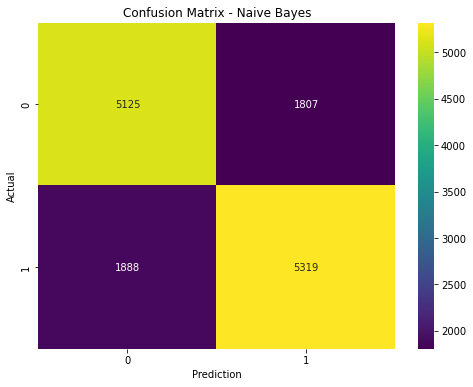

In [29]:
# heatmap matrix
plt.figure(figsize = (8,6))
sns.heatmap(matrix_nb, annot = True, fmt = ".0f", cmap = 'viridis')
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [30]:
# NB classification report
report_nb = metrics.classification_report(y_test, y_pred)
print(report_nb)


              precision    recall  f1-score   support

         0.0       0.73      0.74      0.74      6932
         1.0       0.75      0.74      0.74      7207

    accuracy                           0.74     14139
   macro avg       0.74      0.74      0.74     14139
weighted avg       0.74      0.74      0.74     14139



Naive Bayes yields a pretty good result. The recall value is 74%, which is pretty good.
Now I will evaluate the model using Stratified K-Fold Cross Validation with 10 folds.

In [31]:
from sklearn.model_selection import cross_val_score

In [32]:
# cross validate
scores_nb = cross_val_score(cnb, X, y, cv=10)
print(scores_nb)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_nb.mean(), scores_nb.std()))

[0.72545969 0.72602546 0.73786957 0.73192814 0.73376715 0.72867449
 0.74451832 0.7392842  0.73900127 0.7464988 ]
0.74 accuracy with a standard deviation of 0.01


This model performs pretty well across the entire data.

### 2. Random Forest



Random Forest is an ensemble method for classification using multiple decision trees. I am going to use Random Forest because it is useful for application where accuracy matters and it is suitable for large data sets. It is good for both discrete and continuous variables. Preprocessing is also quite easy. 

In [33]:
# drop target from X and save the target to y
X = data.drop('Diabetes_binary', axis = 1)
y = data['Diabetes_binary']
# split data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(56553, 14)
(56553,)
(14139, 14)
(14139,)


In [34]:
from sklearn.ensemble import RandomForestClassifier


In [35]:
# build random forest model
rf = RandomForestClassifier(random_state = 1, max_features = 'sqrt', n_jobs = 1, verbose = 1)
# train the model
%time rf.fit(X_train, y_train)
# mean accuracy on test data and labels
rf.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 7.93 s, sys: 206 ms, total: 8.14 s
Wall time: 11.5 s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished


0.7242379234740788

In [36]:
# get the predictions
y_pred = rf.predict(X_test)
print(y_pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[1. 0. 0. ... 1. 0. 1.]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


Now I am going to evaluate the model with confusion matrix, accuracy, precision, recall and F1 score.

[[4731 2201]
 [1698 5509]]


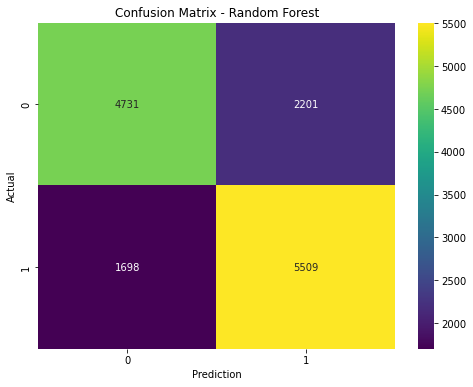

In [37]:
# confusion matrix to evaluate model
matrix_rf = metrics.confusion_matrix(y_test, y_pred)
print(matrix_rf)

# heatmap matrix
plt.figure(figsize = (8,6))
sns.heatmap(matrix_rf, annot = True, fmt = ".0f", cmap = 'viridis')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [38]:
# RF classification report
report_rf = metrics.classification_report(y_test, y_pred)
print(report_rf)


              precision    recall  f1-score   support

         0.0       0.74      0.68      0.71      6932
         1.0       0.71      0.76      0.74      7207

    accuracy                           0.72     14139
   macro avg       0.73      0.72      0.72     14139
weighted avg       0.72      0.72      0.72     14139



In [39]:
# cross validate
scores_rf = cross_val_score(rf, X, y, cv=10)
print(scores_rf)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_rf.mean(), scores_rf.std()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[0.72319661 0.71711457 0.72655255 0.71608431 0.7271184  0.72839157
 0.73390862 0.72358184 0.72527939 0.73730372]
0.73 accuracy with a standard deviation of 0.01


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


Although this model performs pretty well across the entire data, it is not better than Naive Bayes, which is a bit surprising. 

### 3. K Nearest Neighbors


Finally, I am going to test out kNN for this dataset since it is fairly simple to implement and it does not have any assumption on the data. Also, since my categorical variables are already in a numerical format, I don't have to use One-hot encoding for preprocessing. 

In [40]:
from sklearn.preprocessing import StandardScaler

In [41]:
# make scaler
scaler = StandardScaler()

In [42]:
from sklearn.neighbors import KNeighborsClassifier

In [43]:
# build knn model
knn = KNeighborsClassifier()

In [44]:
from sklearn.pipeline import Pipeline

In [45]:
# create a knn pipeline for scaling and modeling
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])


In [46]:
# train the model
knn_pipe.fit(X_train, y_train)
knn_pipe.score(X_test, y_test)

0.713911874955796

In [47]:
# get the predictions
y_pred = knn_pipe.predict(X_test)
# confusion matrix
matrix_knn = metrics.confusion_matrix(y_test, y_pred)
print(matrix_knn)

[[4721 2211]
 [1834 5373]]


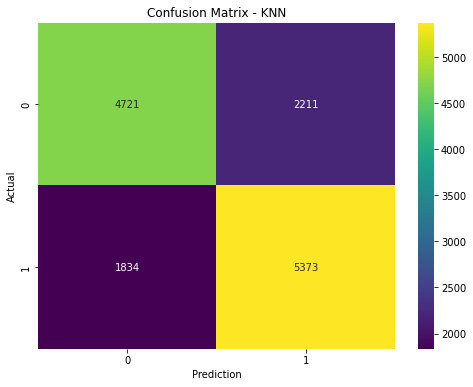

In [48]:
# heatmap matrix
plt.figure(figsize = (8,6))
sns.heatmap(matrix_knn, annot = True, fmt = ".0f", cmap = 'viridis')
plt.title("Confusion Matrix - KNN")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [49]:
# KNN classification report
report_knn = metrics.classification_report(y_test, y_pred)
print(report_knn)

              precision    recall  f1-score   support

         0.0       0.72      0.68      0.70      6932
         1.0       0.71      0.75      0.73      7207

    accuracy                           0.71     14139
   macro avg       0.71      0.71      0.71     14139
weighted avg       0.71      0.71      0.71     14139



In [50]:
# cross validate
scores_knn = cross_val_score(knn, X, y, cv=10)
print(scores_knn)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_knn.mean(), scores_knn.std()))

[0.6844413  0.68472419 0.69472344 0.68128448 0.69670392 0.69189419
 0.69118687 0.6903381  0.69231857 0.69571368]
0.69 accuracy with a standard deviation of 0.00


Out of all the models, kNN has the worst performance. However, considering its simplicity and the fact that the results are not significantly different from the other 2, it is still pretty good.

## Conclusion